loading data >>>>>>>>>>>>>>>>>>>>>
0 {'0': 3025}
1 {'0': 3025, '1': 5959}
2 {'0': 3025, '1': 5959, '2': 56}
building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


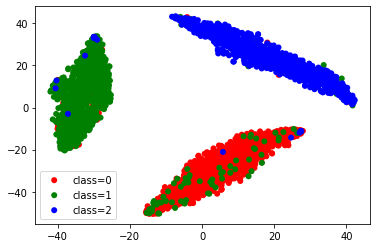

In [13]:
import sys 
sys.path.append('/ossfs/workspace/jd_paper/mydata/')
sys.path.append('/ossfs/workspace/jd_paper/HGT-semi/')
from model_k import *
# from model_orig import *
from utils.data import load_data
from build_graph_kk import build_heterograph
import argparse
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

def mat2tensor(mat):
    if type(mat) is np.ndarray:
        return torch.from_numpy(mat).type(torch.FloatTensor)
    return sp_to_spt(mat)

def plot(args, G, dataset):
    feats_type = args.feats_type
    features_list, adjM, labels, train_val_test_idx, dl = load_data(dataset)
    features_list = [mat2tensor(features).to(device) for features in features_list]
    if feats_type == 0:
        in_dims = [features.shape[1] for features in features_list]
    elif feats_type == 1 or feats_type == 5:
        save = 0 if feats_type == 1 else 2
        in_dims = []
        for i in range(0, len(features_list)):
            if i == save:
                in_dims.append(features_list[i].shape[1])
            else:
                in_dims.append(10)
                features_list[i] = torch.zeros((features_list[i].shape[0], 10)).to(device)
    elif feats_type == 2 or feats_type == 4:
        save = feats_type - 2
        in_dims = [features.shape[0] for features in features_list]
        for i in range(0, len(features_list)):
            if i == save:
                in_dims[i] = features_list[i].shape[1]
                continue
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    elif feats_type == 3:
        in_dims = [features.shape[0] for features in features_list]
        for i in range(len(features_list)):
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    # 添加图特征
    for ntype in G.ntypes:
        G.nodes[ntype].data["inp"] = features_list[int(ntype)]
    model = HGT(G, n_inps=in_dims, n_hid=args.hidden_dim, n_out=labels.max().item()+1, n_layers=args.num_layers, n_heads=args.num_heads, unlabel_idx=None, use_norm=args.use_norm).to(device)

    # save_path = "checkpoint/checkpoint_{}_{}l_{}th.pt".format(args.dataset, args.num_layers, 0)
    # save_path = "checkpoint/checkpoint_{}_{}l_{}th_aug.pt".format(args.dataset, args.num_layers, 0)
    # save_path = "checkpoint/checkpoint_{}_{}l_{}th_aug_add.pt".format(args.dataset, args.num_layers, 0)
    save_path = "/ossfs/workspace/jd_paper/result/tcheckpoint_consis_ACM_5l_4th.pt"
    
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint)
    model.eval()
    logits, embeddings = model(G, '0', 0)
    # print(embeddings)
    # print(labels)
    # unique, counts = np.unique(labels, return_counts=True)
    # print(counts)

    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    embeddings = embeddings.cpu().detach().numpy()
    X_embedded = TSNE(n_components=2).fit_transform(embeddings)
    # print(X_embedded)
    fig, ax = plt.subplots()
    for i, color in enumerate(["r", "g", "b"]):
        x = X_embedded[labels==i][:,0]
        y = X_embedded[labels==i][:,1]
        ax.scatter(x, y, c=color, label="class={}".format(i), alpha=1, edgecolors="none")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    ap = argparse.ArgumentParser(description='MRGNN testing for the DBLP dataset')
    ap.add_argument('--feats-type', type=int, default=0,
                    help='Type of the node features used. ' +
                            '0 - loaded features; ' +
                            '1 - only target node features (zero vec for others); ' +
                            '2 - only target node features (id vec for others); ' +
                            '3 - all id vec. Default is 2;' +
                        '4 - only term features (id vec for others);' + 
                        '5 - only term features (zero vec for others).')
    ap.add_argument('--hidden_dim', type=int, default=64, help='Dimension of the node hidden state. Default is 64.')
    ap.add_argument('--num_heads', type=int, default=8, help='Number of the attention heads. Default is 8.')
    ap.add_argument('--epoch', type=int, default=300, help='Number of epochs.')
    ap.add_argument('--patience', type=int, default=30, help='Patience.')
    ap.add_argument('--repeat', type=int, default=5, help='Repeat the training and testing for N times. Default is 1.')
    ap.add_argument('--num_layers', type=int, default=5) #5
    ap.add_argument('--lr', type=float, default=1e-2) #5e-3
    ap.add_argument('--dropout', type=float, default=0)
    ap.add_argument('--weight-decay', type=float, default=1e-3) #1e-4
    ap.add_argument('--slope', type=float, default=0.05)
    ap.add_argument('--dataset', type=str, default='ACM')  #  ACM
    ap.add_argument('--edge-feats', type=int, default=64)
    ap.add_argument('--device', type=int, default=0)
    ap.add_argument('--schedule_step', type=int, default=300)
    ap.add_argument('--use_norm', type=bool, default=True)
    ap.add_argument('--rate', type=float, default=0.2)
    ap.add_argument('--num_cf_list', type=list, default=[0,5]) #[0,5,10,15]
    ap.add_argument('--tem', type=float, default=0.2)
    
    args = ap.parse_args(args=[])
    G, dataset = build_heterograph(args)
    plot(args, G, 'ACM')

In [8]:
1

1

loading data >>>>>>>>>>>>>>>>>>>>>
0 {'0': 3025}
1 {'0': 3025, '1': 5959}
2 {'0': 3025, '1': 5959, '2': 56}
building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


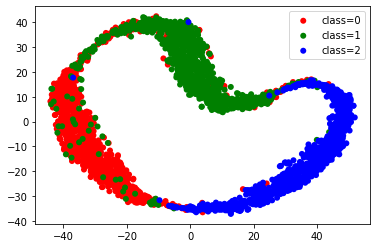

In [23]:
import dgl
import torch
import argparse
import numpy as np

import sys 
sys.path.append("..")
sys.path.append('/ossfs/workspace/jd_paper/mydata/')
sys.path.append('/ossfs/workspace/jd_paper/HGT-semi/')
from model_k import *
from utils.data import load_data
from build_graph_kk import build_heterograph

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
def mat2tensor(mat):
    if type(mat) is np.ndarray:
        return torch.from_numpy(mat).type(torch.FloatTensor)
    return sp_to_spt(mat)

def plot(args, G, dataset):
    feats_type = args.feats_type
    features_list, adjM, labels, train_val_test_idx, dl = load_data(dataset)
    features_list = [mat2tensor(features).to(device) for features in features_list]
    if feats_type == 0:
        in_dims = [features.shape[1] for features in features_list]
    elif feats_type == 1 or feats_type == 5:
        save = 0 if feats_type == 1 else 2
        in_dims = []
        for i in range(0, len(features_list)):
            if i == save:
                in_dims.append(features_list[i].shape[1])
            else:
                in_dims.append(10)
                features_list[i] = torch.zeros((features_list[i].shape[0], 10)).to(device)
    elif feats_type == 2 or feats_type == 4:
        save = feats_type - 2
        in_dims = [features.shape[0] for features in features_list]
        for i in range(0, len(features_list)):
            if i == save:
                in_dims[i] = features_list[i].shape[1]
                continue
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    elif feats_type == 3:
        in_dims = [features.shape[0] for features in features_list]
        for i in range(len(features_list)):
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    # 添加图特征
    for ntype in G.ntypes:
        G.nodes[ntype].data["inp"] = features_list[int(ntype)]
    model = HGT(G, n_inps=in_dims, n_hid=args.hidden_dim, n_out=labels.max().item()+1, n_layers=args.num_layers, n_heads=args.num_heads, unlabel_idx=None, use_norm=args.use_norm).to(device)
    save_path = "/ossfs/workspace/jd_paper/result/checkpoint_ACM_8l_1th.pt".format(args.dataset, args.num_layers, 0)
    # save_path = "checkpoint/checkpoint_{}_{}l_{}th_aug.pt".format(args.dataset, args.num_layers, 0)
    # save_path = "checkpoint/checkpoint_{}_{}l_{}th_aug_add.pt".format(args.dataset, args.num_layers, 0)
    # save_path = "checkpoint/checkpoint_{}_{}l_{}th_aug_del.pt".format(args.dataset, args.num_layers, 0)
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint)
    model.eval()
    logits, embeddings = model(G, "0", 0)
    # print(embeddings)
    # print(labels)
    # unique, counts = np.unique(labels, return_counts=True)
    # print(counts)

    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    embeddings = embeddings.detach().cpu().numpy()
    X_embedded = TSNE(n_components=2).fit_transform(embeddings)
    # print(X_embedded)
    fig, ax = plt.subplots()
    for i, color in enumerate(["r", "g", "b"]):
        x = X_embedded[labels==i][:,0]
        y = X_embedded[labels==i][:,1]
        ax.scatter(x, y, c=color, label="class={}".format(i), edgecolors="none") # alpha=0.3
    ax.legend()
    plt.show()

if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="testing")
    ap.add_argument("--feats-type", type=int, default=1,
                    help="Type of the node features used. " +
                         "0 - loaded features; " +
                         "1 - only target node features (zero vec for others); " +
                         "2 - only target node features (id vec for others); " +
                         "3 - all id vec. Default is 2;" +
                         "4 - only term features (id vec for others);" + 
                         "5 - only term features (zero vec for others).")
    ap.add_argument("--num_layers", type=int, default=8) # 8
    ap.add_argument("--num_heads", type=int, default=8) # 8
    ap.add_argument("--hidden_dim", type=int, default=128) # 64, 128
    ap.add_argument("--dropout", type=float, default=0) # 0
    ap.add_argument("--use_norm", type=bool, default=True)
    ap.add_argument("--rate", type=float, default=0.2)
    ap.add_argument("--dataset", type=str, default="ACM") # DBLP, ACM
    ap.add_argument("--repeat", type=int, default=5, help="Repeat the training and testing for N times. Default is 1.")
    ap.add_argument("--epoch", type=int, default=300) # 300, 150
    ap.add_argument("--lr", type=float, default=1e-2)
    ap.add_argument("--weight-decay", type=float, default=1e-3)
    ap.add_argument("--schedule_step", type=int, default=300) # 300, 150
    ap.add_argument("--patience", type=int, default=30, help="Patience.") # 30, 20
    ap.add_argument('--device', type=int, default=0)
    args = ap.parse_args(args=[])
    g, dataset = build_heterograph(args)
    plot(args, g, "ACM")

